# Dataset import

In [1]:
import csv
import matplotlib.pyplot as plt
import pickle
import random
import json
from multiprocess.pool import Pool

import utils
import predictors
import kernels
import validation
from datatypes import BinaryClassifier

X = []
Y = []

with open("your_dataset.csv") as f:
    csv_file = csv.reader(f)
    next(csv_file)  # skip header

    for line in csv_file:
        X.append((1.0,) + tuple(float(x) for x in line[:10]))
        Y.append(int(line[10]))

trainX, testX = X[:7000], X[7000:]
trainY, testY = Y[:7000], Y[7000:]


def train_by_steps(
    model: BinaryClassifier,
    epoch_max: int,
    epoch_step: int,
    log: bool=True,
    trainX=trainX,
    trainY=trainY,
    testX=testX,
    testY=testY,
):
    warm = False

    train_err = []
    test_err = []
    epochs = range(epoch_step, epoch_max + 1, epoch_step)

    for e in epochs:
        model.fit(trainX, trainY, warm_start=warm)
        warm = True

        if log:
            print("Epoch:", e, end="\r")

        testY_pred = model.predict(testX)
        trainY_pred = model.predict(trainX)

        test_err.append(utils.zo_loss(testY, testY_pred))
        train_err.append(utils.zo_loss(trainY, trainY_pred))
    if log:
        print()
    return train_err, test_err, epochs


len(X)

10000

# Perceptron

Epoch: 2000


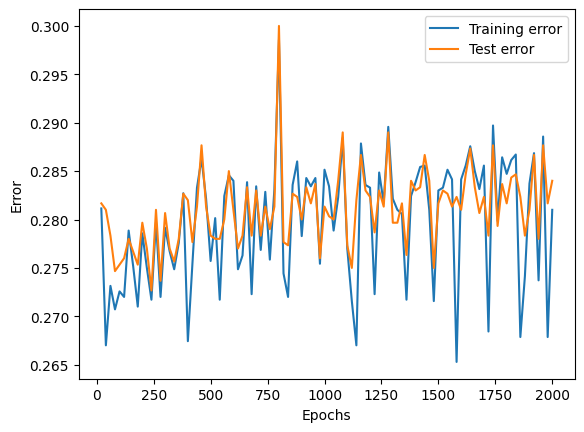

In [ ]:
model = predictors.Perceptron(epochs=20)

train_err, test_err, epochs = train_by_steps(model, 2000, 20)

# with open("../models/perceptron.pkl", "x") as f:
#     pickle.dump(model, f.buffer)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Using quadratic features

Epoch: 6000


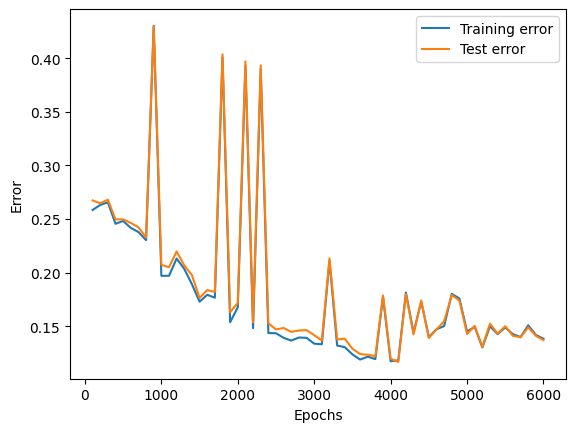

In [2]:
epoch_step = 100
model = predictors.Perceptron(epochs=epoch_step)

quad_trainX = [utils.quadratic_extraction(x[1:]) for x in trainX]
quad_testX = [utils.quadratic_extraction(x[1:]) for x in testX]
train_err, test_err, epochs = train_by_steps(model, 6001, epoch_step, trainX=quad_trainX, testX=quad_testX)

plt.plot(epochs, train_err)
plt.plot(epochs, test_err)
plt.legend(["Training error", "Test error"])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Polynomial Kernel

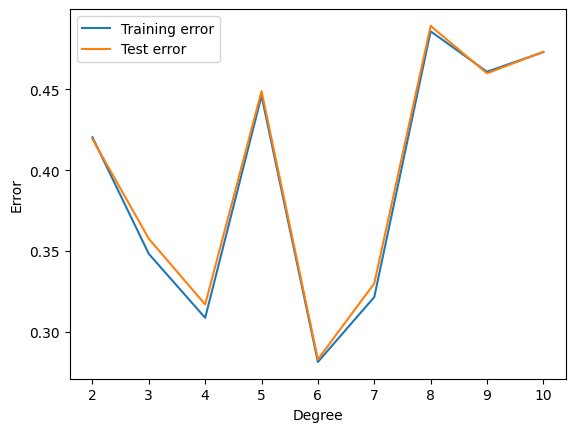

In [7]:
def create_and_train(deg):
    model = predictors.KernelPerceptron(kernels.polynomial(deg))
    model.fit(trainX, trainY)

    trainY_pred = model.predict(trainX)
    testY_pred = model.predict(testX)

    return utils.zo_loss(trainY, trainY_pred), utils.zo_loss(testY, testY_pred)


degrees = list(range(2, 11))

with Pool() as pool:
    result = pool.map(create_and_train, degrees)

train_errs = [x[0] for x in result]
test_errs = [x[1] for x in result]

plt.xlabel("Degree")
plt.ylabel("Error")
plt.plot(degrees, train_errs)
plt.plot(degrees, test_errs)
plt.legend(["Training error", "Test error"])
plt.show()

## Gaussian Kernel

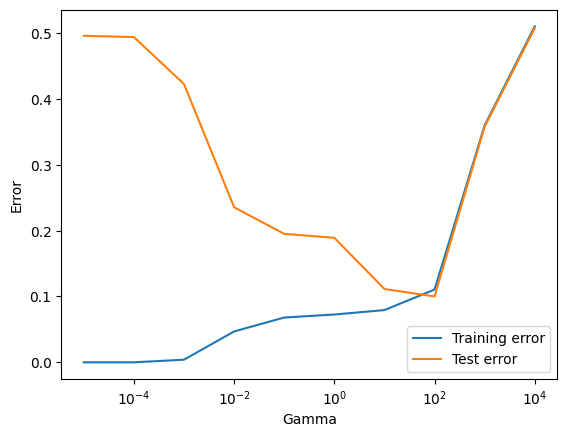

In [2]:
def create_and_train(gamma):
    model = predictors.KernelPerceptron(kernels.gaussian(gamma))
    model.fit(trainX, trainY)

    trainY_pred = model.predict(trainX)
    testY_pred = model.predict(testX)

    return utils.zo_loss(trainY, trainY_pred), utils.zo_loss(testY, testY_pred)

gammas = [pow(10, i) for i in range(-5, 5)]

with Pool() as pool:
    result = pool.map(create_and_train, gammas)

train_errs = [x[0] for x in result]
test_errs = [x[1] for x in result]

plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Error")
plt.plot(gammas, train_errs)
plt.plot(gammas, test_errs)
plt.legend(["Training error", "Test error"])
plt.show()

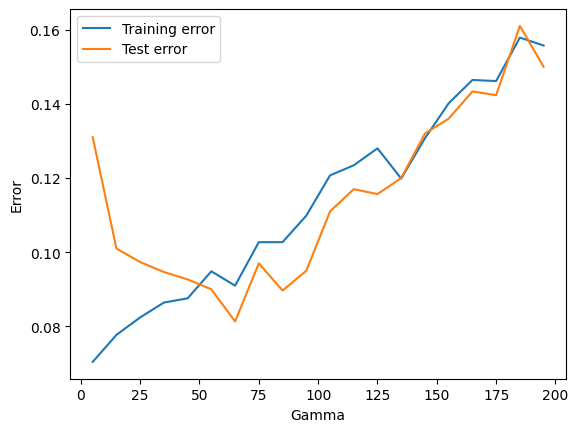

In [4]:
def create_and_train(gamma):
    model = predictors.KernelPerceptron(kernels.gaussian(gamma))
    model.fit(trainX, trainY)

    trainY_pred = model.predict(trainX)
    trainY_test = model.predict(testX)

    return utils.zo_loss(trainY, trainY_pred), utils.zo_loss(testY, trainY_test)

gammas = list(range(5, 200, 10))

with Pool() as pool:
    result = pool.map(create_and_train, gammas)

train_errs = [x[0] for x in result]
test_errs = [x[1] for x in result]

plt.xlabel("Gamma")
plt.ylabel("Error")
plt.plot(gammas, train_errs)
plt.plot(gammas, test_errs)
plt.legend(["Training error", "Test error"])
plt.show()

# SVM

## Using hinge loss

### Parameter tuning via nested cross validation

In [ ]:
params = {
    "epochs": [100, 500, 1000, 2000, 5000, 7500, 10000],
    "learning_rate": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
    "regularization": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
}

best_param, loss = validation.nested_cross_validation(
    predictors.SVM,
    X,
    Y,
    10,
    params
)

best_param, loss

Epoch: 20000
Epoch: 20000
Epoch: 20000
Epoch: 20000


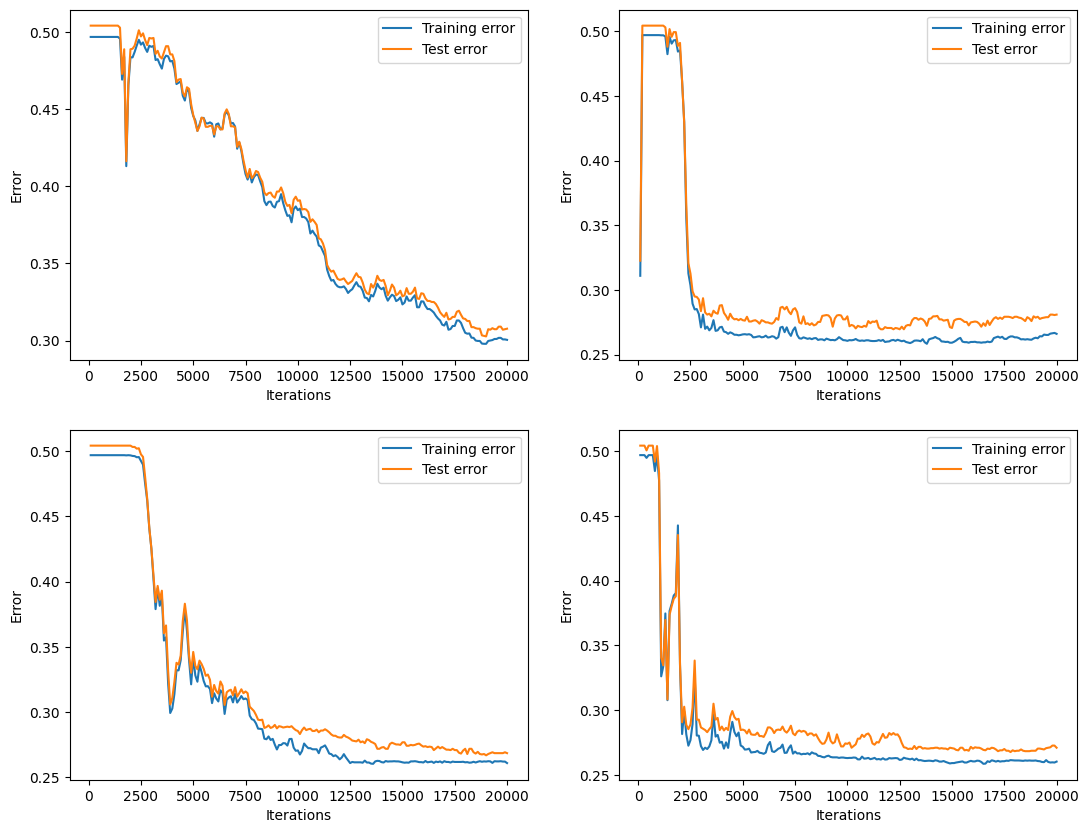

In [5]:
try:
    del best_param["epochs"]
except:
    pass
fig, axs = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(13)

for i in range(4):
    model = predictors.SVM(**best_param, epochs=100, random=random.Random(i))
    train_err, test_err, epochs = train_by_steps(model, 20000, 100)

    ax = axs[i//2][i%2]

    ax.plot(epochs, train_err)
    ax.plot(epochs, test_err)
    ax.legend(["Training error", "Test error"])
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Error")

plt.show()

#### Quadratic features

In [4]:
params = {
    "epochs": [100, 500, 1000, 2000, 5000, 7500, 10000],
    "learning_rate": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
    "regularization": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
}

quad_X = [utils.quadratic_extraction(x[1:]) for x in X]
best_param, loss = validation.nested_cross_validation(
    predictors.SVM,
    quad_X,
    Y,
    10,
    params
)

best_param, loss

({'epochs': 1000, 'learning_rate': 0.1, 'regularization': 0.001}, 0.3)

Epoch: 5000
Epoch: 5000
Epoch: 5000
Epoch: 5000


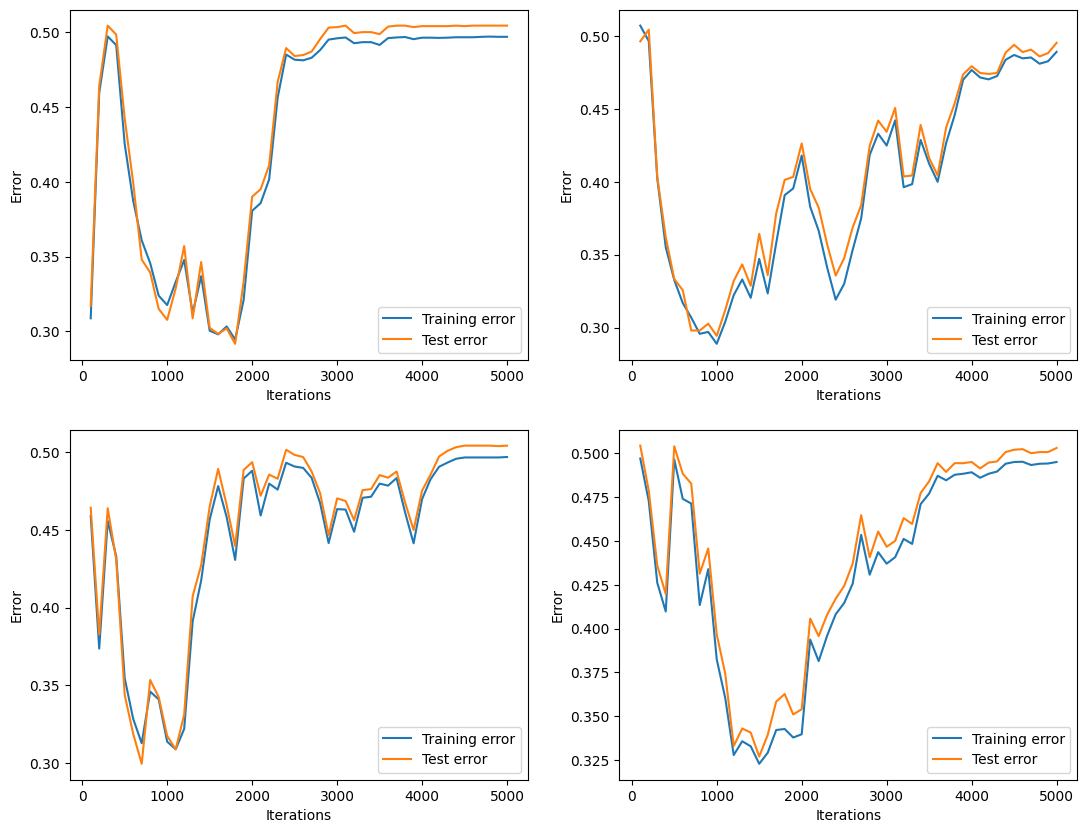

In [6]:
try:
    del best_param["epochs"]
except:
    pass

fig, axs = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(13)

for i in range(4):
    model = predictors.SVM(**best_param, epochs=100, random=random.Random(i))
    train_err, test_err, epochs = train_by_steps(model, 5000, 100, trainX=quad_X[:7000], testX=quad_X[7000:])

    ax = axs[i//2][i%2]

    ax.plot(epochs, train_err)
    ax.plot(epochs, test_err)
    ax.legend(["Training error", "Test error"])
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Error")

plt.show()

## Using logistic loss

### Parameter tuning via nested cross validation

In [ ]:
params = {
    "epochs": [100, 500, 1000, 2000, 5000, 7500, 10000],
    "learning_rate": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
    "regularization": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
    "loss_func": ["logistic"]
}

best_param, loss = validation.nested_cross_validation(
    predictors.SVM,
    X,
    Y,
    10,
    params,
)

best_param, loss

({'epochs': 5000,
  'learning_rate': 0.1,
  'regularization': 0.0001,
  'loss_func': 'logistic'},
 0.252)

Epoch: 20000

Epoch: 20000

Epoch: 20000

Epoch: 20000



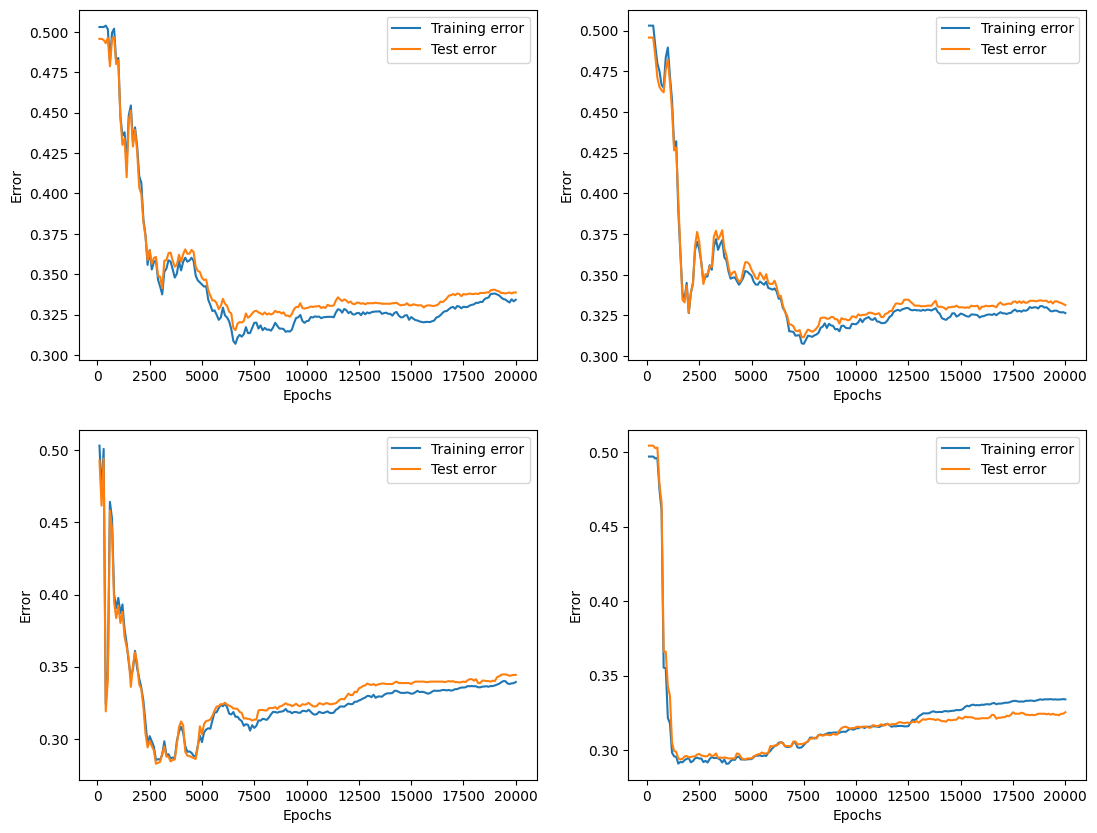

In [ ]:
del best_param["epochs"]
fig, axs = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(13)

for i in range(4):
    model = predictors.SVM(**best_param, epochs=100, random=random.Random(i))
    train_err, test_err, epochs = train_by_steps(model, 20000, 100)
    print()

    ax = axs[i//2][i%2]

    ax.plot(epochs, train_err)
    ax.plot(epochs, test_err)
    ax.legend(["Training error", "Test error"])
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")

plt.show()

#### Quadratic features

In [ ]:
params = {
    "epochs": [100, 500, 1000, 2000, 5000, 7500, 10000],
    "learning_rate": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
    "regularization": [0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
    "expansion": [utils.quadratic_extraction],
    "loss_func": ["logistic"]
}

best_param, loss = validation.nested_cross_validation(
    predictors.SVM,
    X,
    Y,
    10,
    params
)

best_param, loss

## Polynomial kernel

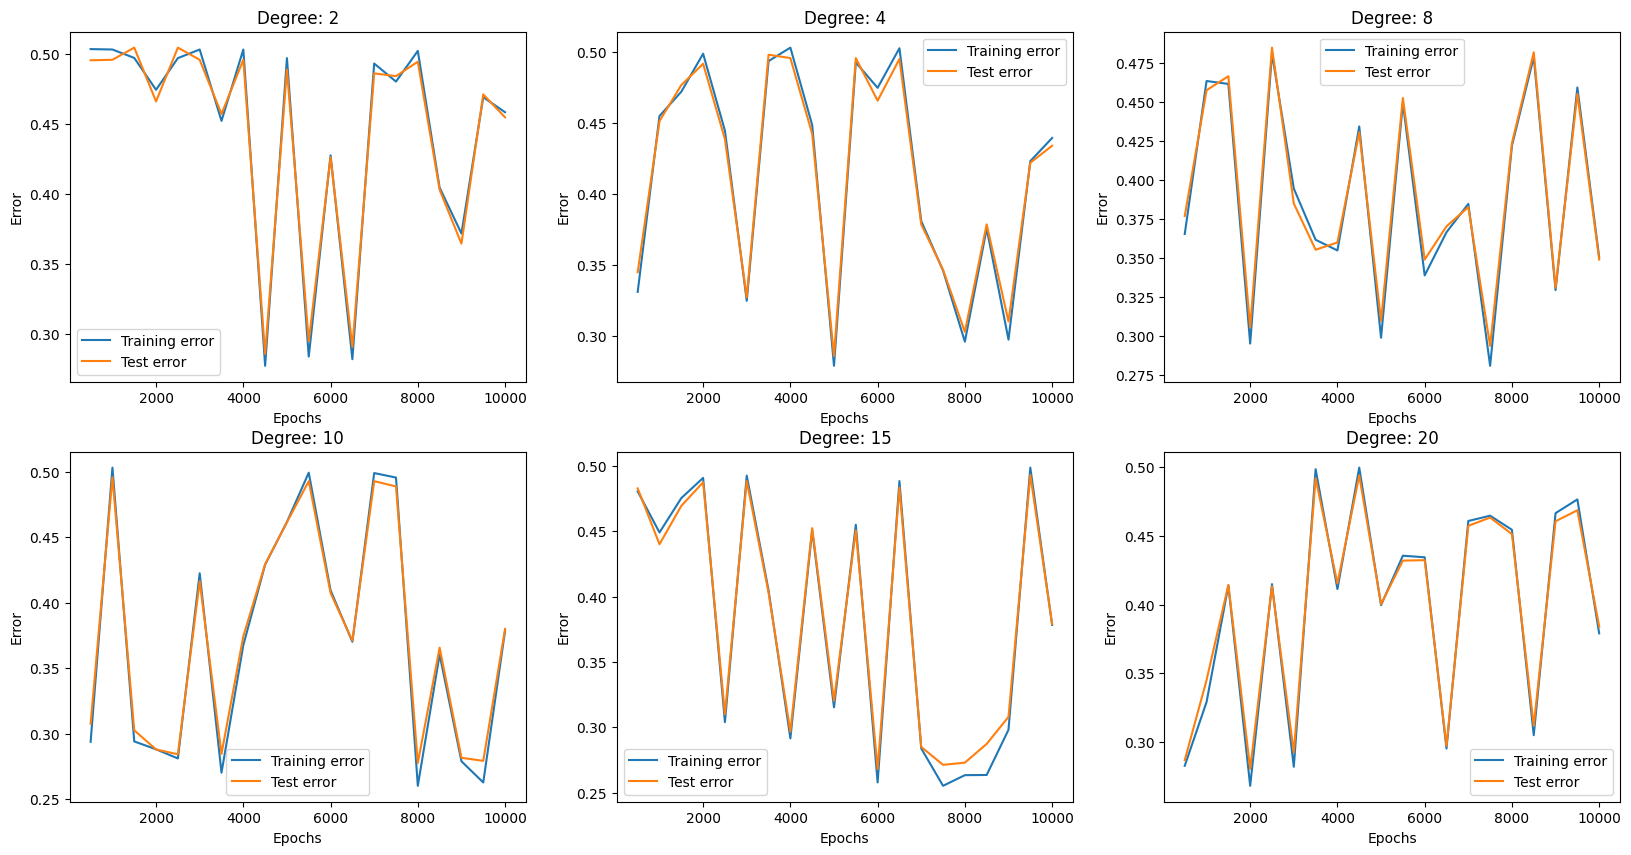

In [12]:
epoch_step = 500

fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)

degrees = [2, 4, 8, 10, 15, 20]

def create_and_train(epoch_step, deg):
    model = predictors.KernelSVM(epochs=epoch_step, kernel=kernels.polynomial(deg))
    train_err, test_err, epochs = train_by_steps(model, 10001, epoch_step, log=False)
    return train_err, test_err, list(epochs)

try:
    with open("../experiments/svm_poly.json") as f:
        data = json.load(f)
        train_err = data["train_err"]
        test_err = data["test_err"]
        epochs = data["epochs"]
except:
    data = {}

    with Pool() as pool:
        results = pool.map(
            lambda d: create_and_train(epoch_step, d), 
            degrees
        )
    
    data["train_err"] = [x[0] for x in results]
    data["test_err"] = [x[1] for x in results]
    data["epochs"] = [x[2] for x in results]

    with open("../experiments/svm_poly.json", "w") as f:
        json.dump(data, f)

for i in range(len(degrees)):
    ax = axs[i//3][i%3]
    ax.set_title(f"Degree: {degrees[i]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.plot(data["epochs"][i], data["train_err"][i])
    ax.plot(data["epochs"][i], data["test_err"][i])
    ax.legend(["Training error", "Test error"])

plt.show()

## Gaussian Kernel

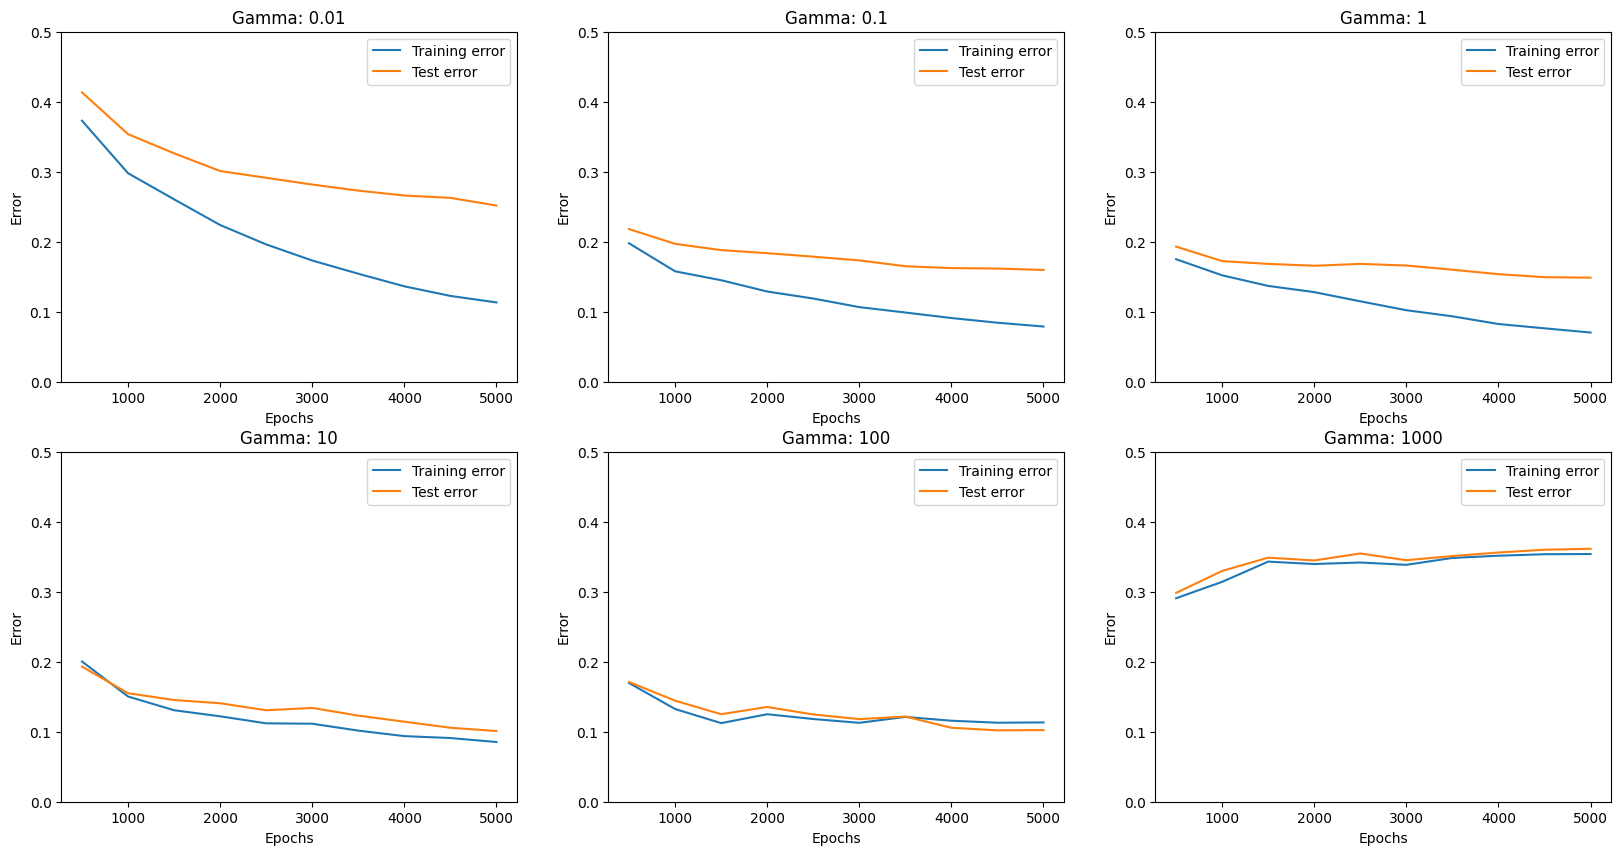

In [4]:
epoch_step = 500

fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)

gammas = [pow(10, i) for i in range(-2, 4)]

def create_and_train(epoch_step, gamma):
    model = predictors.KernelSVM(epochs=epoch_step, kernel=kernels.gaussian(gamma))
    train_err, test_err, epochs = train_by_steps(model, 5001, epoch_step, log=False)
    return train_err, test_err, list(epochs)

try:
    with open("../experiments/svm_gauss.json") as f:
        data = json.load(f)
        train_err = data["train_err"]
        test_err = data["test_err"]
        epochs = data["epochs"]
except:
    data = {}

    with Pool() as pool:
        results = pool.map(
            lambda g: create_and_train(epoch_step, g), 
            gammas
        )
    
    data["train_err"] = [x[0] for x in results]
    data["test_err"] = [x[1] for x in results]
    data["epochs"] = [x[2] for x in results]

    with open("../experiments/svm_gauss.json", "w") as f:
        json.dump(data, f)

for i in range(len(gammas)):
    ax = axs[i//3][i%3]
    ax.set_ylim(0, 0.5)
    ax.set_title(f"Gamma: {gammas[i]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.plot(data["epochs"][i], data["train_err"][i])
    ax.plot(data["epochs"][i], data["test_err"][i])
    ax.legend(["Training error", "Test error"])

plt.show()

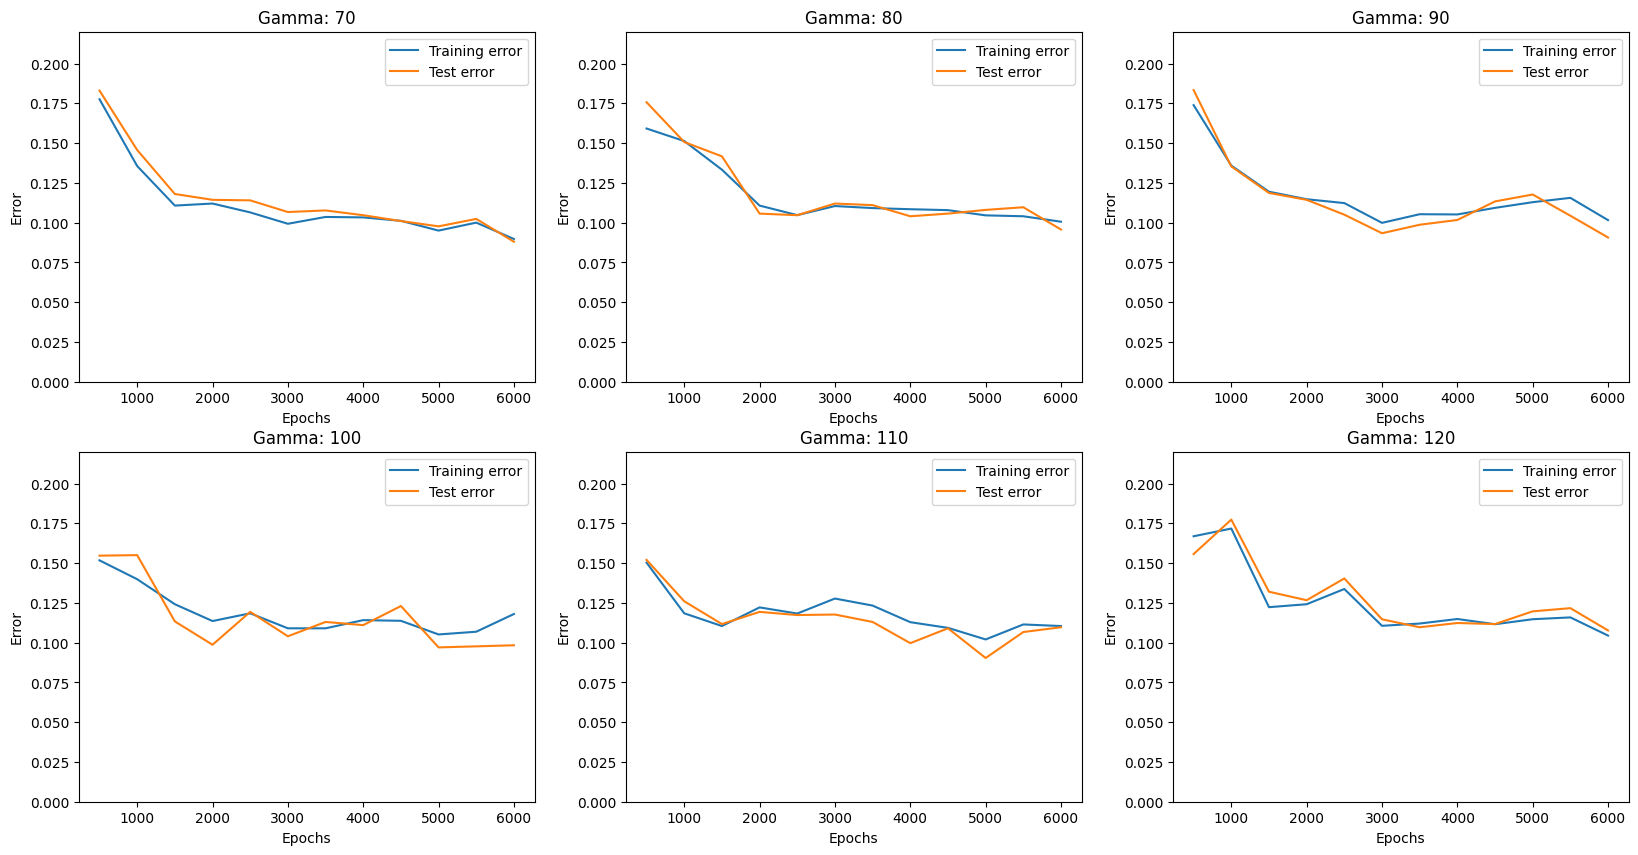

In [10]:
epoch_step = 500

fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)

gammas = list(range(70, 130, 10))

def create_and_train(epoch_step, gamma):
    model = predictors.KernelSVM(epochs=epoch_step, kernel=kernels.gaussian(gamma))
    train_err, test_err, epochs = train_by_steps(model, 6001, epoch_step, log=False)
    return train_err, test_err, list(epochs)

try:
    with open("../experiments/svm_gauss2.json") as f:
        data = json.load(f)
        train_err = data["train_err"]
        test_err = data["test_err"]
        epochs = data["epochs"]
except:
    data = {}

    with Pool() as pool:
        results = pool.map(
            lambda g: create_and_train(epoch_step, g), 
            gammas
        )
    
    data["train_err"] = [x[0] for x in results]
    data["test_err"] = [x[1] for x in results]
    data["epochs"] = [x[2] for x in results]

    with open("../experiments/svm_gauss2.json", "w") as f:
        json.dump(data, f)

for i in range(len(gammas)):
    ax = axs[i//3][i%3]
    ax.set_ylim(0, 0.22)
    ax.set_title(f"Gamma: {gammas[i]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Error")
    ax.plot(data["epochs"][i], data["train_err"][i])
    ax.plot(data["epochs"][i], data["test_err"][i])
    ax.legend(["Training error", "Test error"])

plt.show()